<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_10_Metrics_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Applications: MNIST

In [2]:
# Import the small MNIST dataset that comes with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract the labels and remove them from data
labels = data[:,0]
data = data[:,1:]

# Normalize data on range 0-1
dataNorm = data/np.max(data)

In [3]:
# Convert the data and labels into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Use sikitlearn to split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert them into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into data Loader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
# Create a model class
def createTheMNISTNet():

    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Define Input Layer
            self.input = nn.Linear(784,64)

            # Define the hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.fc3 = nn.Linear(32,32)

            # Define the Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            return self.output(x)
    
    # Create e model instance
    net = MNISTNet()

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [5]:
# Create a function to train a model
def function2trainthemodel():

    # Define the number of epochs
    numepochs = 25

    # Create new model instance
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Initiate batch accuracy and losses
        batchAcc = []
        batchLoss = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass and Loses
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses from this batch
            batchLoss.append(loss.item())

            # Accuracy of this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
            # End of the batch
        
        # Training Accuracy for each epoch
        trainAcc.append(np.mean(batchAcc))

        # Training LOsses for each EPoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        
        # Test Losses
        losses[epochi,1] = lossfun(yHat,y).item()

        # Test Accuracy for each Epoch
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    
    # Return the results
    return trainAcc, testAcc, losses, net

In [6]:
# Run the model
trainAcc, testAcc, losses, net = function2trainthemodel()

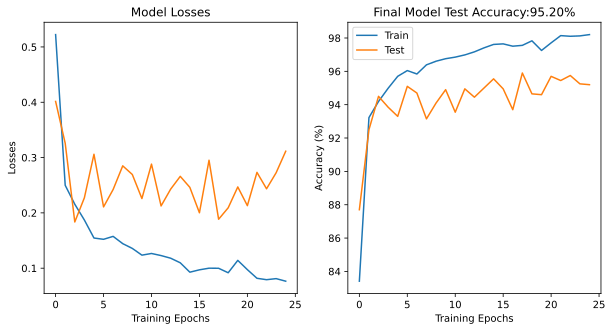

In [7]:
# Visualize the whole thing
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc,label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final Model Test Accuracy:{testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [8]:
# Compute the performance measures
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat,axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
test_predictions

tensor([3, 3, 9,  ..., 3, 2, 2])

In [9]:
print(train_predictions.shape)
print(test_predictions.shape)

torch.Size([18000])
torch.Size([2000])


In [10]:
# There are 10 classes giving 10 precision values
# Option 1: Compute Precision for each class (each number) (10 values in this case)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions,average=None)

array([0.99329234, 0.99646821, 0.98715084, 0.98037077, 0.99189346,
       0.99299809, 0.99617904, 0.99837925, 0.94897959, 0.95860215])

In [11]:
# Option 2: Compute average precision, waighted by N (number of samples per class)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions,average="weighted")

0.9847565953450551

In [12]:
# Option 3: Compute average precision, unweighted (same as weighted if category N (sample size) is same)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions,average="macro")

0.984431375165124

In [13]:
# Initialize the vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# if we used softmax, then instead of zero we would need 0.5
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1],train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1],train_predictions, average="weighted")
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")

# test scores
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")

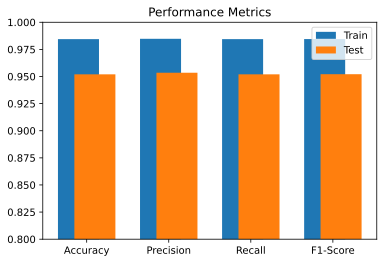

In [14]:
# Plot them
plt.bar(np.arange(4)-0.1, train_metrics, 0.5)
plt.bar(np.arange(4)+0.1, test_metrics, 0.5)
plt.xticks([0,1,2,3], ["Accuracy", "Precision", "Recall", "F1-Score"])
plt.legend(["Train", "Test"])
plt.ylim([0.8,1.0])
plt.title("Performance Metrics")
plt.show()
# In this case the model is not biased

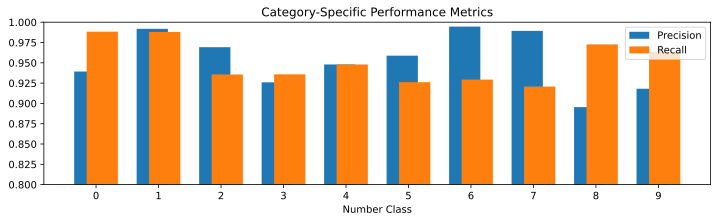

In [15]:
# Bar Graph of class specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall = skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average=None)

fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-0.1, precision, 0.5)
plt.bar(np.arange(10)+0.1, recall, 0.5)
plt.xticks(range(10), range(10))
plt.legend(["Precision", "Recall"])
plt.ylim([0.8,1.0])
plt.xlabel("Number Class")
plt.title("Category-Specific Performance Metrics")
plt.show()

In [16]:
# Confusion Matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions, normalize="true")
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize="true")

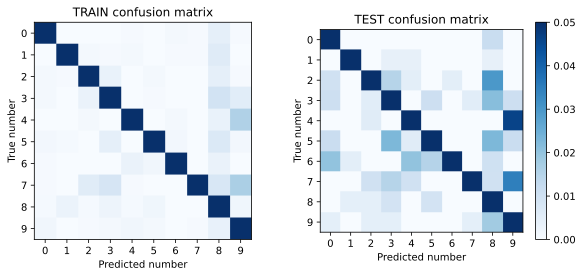

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during train
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during test
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

# Unbalanced Data from MNIST

Reduce the number of 7's to 500 and run the model. Check the performance metrics for each class

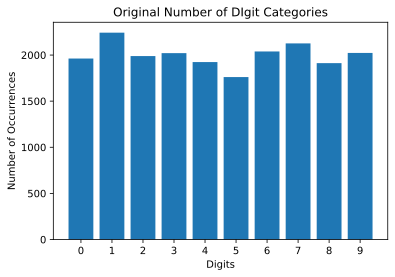

In [18]:
# category counts
catcounts = np.unique(labels,return_counts=True)
# visualize on a barchart
plt.bar(catcounts[0],catcounts[1])
plt.xlabel("Digits")
plt.ylabel("Number of Occurrences")
plt.title("Original Number of DIgit Categories")
plt.xticks(range(10))
plt.show()

In [19]:
# Locate and remove all 7's in the data
# find all the 7's
where7s = np.where(labels==7)[0]

# Removde all 7's except 500
N2remove = where7s.shape[0] - 500
print(N2remove)

1626


In [20]:
# pick that number of 7's at random
remove7s = np.random.choice(where7s,size=N2remove,replace=False)

# and remove them from the data!
print("Sizes before removing:")
print(dataNorm.shape)
print(labels.shape)

dataNorm = np.delete(dataNorm, remove7s, axis=0)
labels = np.delete(labels, remove7s)

print("\n\nSizes after removing:")
print(dataNorm.shape)
print(labels.shape)

Sizes before removing:
(20000, 784)
(20000,)


Sizes after removing:
(18374, 784)
(18374,)


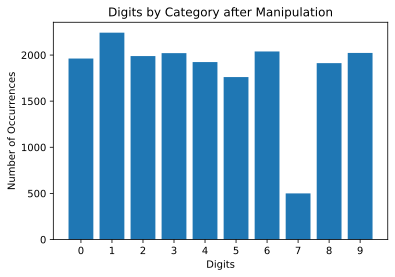

In [21]:
# Visualize the data after the changes
catcounts = np.unique(labels,return_counts=True)
plt.bar(catcounts[0],catcounts[1])
plt.xlabel("Digits")
plt.ylabel("Number of Occurrences")
plt.title("Digits by Category after Manipulation")
plt.xticks(range(10))
plt.show()

In [22]:
# Convert the data and labels into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Use sikitlearn to split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert them into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into data Loader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [23]:
# Run the model
trainAcc, testAcc, losses, net = function2trainthemodel()

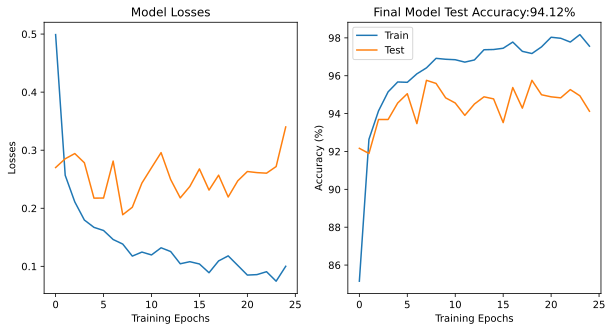

In [24]:
# Visualize the whole thing
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc,label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final Model Test Accuracy:{testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [25]:
# Compute the performance measures
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat,axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
test_predictions

tensor([9, 2, 9,  ..., 4, 2, 7])

In [26]:
# Initialize the vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# if we used softmax, then instead of zero we would need 0.5
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1],train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1],train_predictions, average="weighted")
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")

# test scores
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")

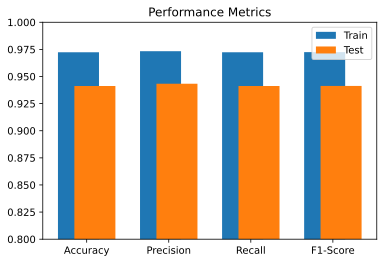

In [27]:
# Plot them
plt.bar(np.arange(4)-0.1, train_metrics, 0.5)
plt.bar(np.arange(4)+0.1, test_metrics, 0.5)
plt.xticks([0,1,2,3], ["Accuracy", "Precision", "Recall", "F1-Score"])
plt.legend(["Train", "Test"])
plt.ylim([0.8,1.0])
plt.title("Performance Metrics")
plt.show()
# Still no change in 4 metrics

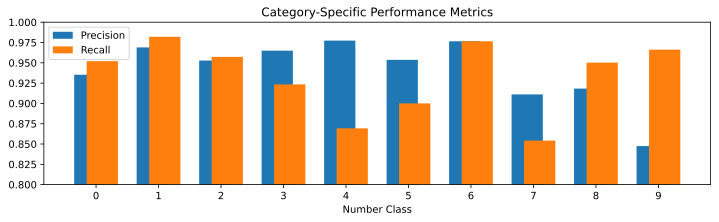

In [28]:
# Bar Graph of class specific precision and recall for test data
precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall = skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average=None)

fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-0.1, precision, 0.5)
plt.bar(np.arange(10)+0.1, recall, 0.5)
plt.xticks(range(10), range(10))
plt.legend(["Precision", "Recall"])
plt.ylim([0.8,1.0])
plt.xlabel("Number Class")
plt.title("Category-Specific Performance Metrics")
plt.show()
# Metrics for 7 are down

In [29]:
# Confusion Matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions, normalize="true")
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize="true")

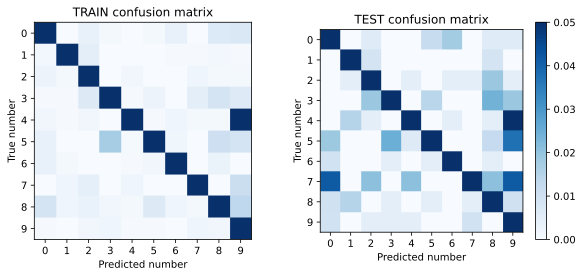

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during train
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during test
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

# Computation Time

There are two ways to measure the computation time:

a) Exact time using system clock. This is accurate to the sub-milisecond

b) Rough Computation Time either using a stopwatch or the colab time. This is accurate within seconds

In [31]:
import time

# Import the small MNIST dataset that comes with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract the labels and remove them from data
labels = data[:,0]
data = data[:,1:]

# Normalize data on range 0-1
dataNorm = data/np.max(data)

In [32]:
# Convert the data and labels into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Use sikitlearn to split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert them into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into data Loader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [33]:
# Create a model class
def createTheMNISTNet():

    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Define Input Layer
            self.input = nn.Linear(784,64)

            # Define the hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.fc3 = nn.Linear(32,32)

            # Define the Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            return self.output(x)
    
    # Create e model instance
    net = MNISTNet()

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [34]:
# Create a function to train a model
def function2trainthemodel():

    # Start the timer
    timerInFunction = time.process_time()

    # Define the number of epochs
    numepochs = 10

    # Create new model instance
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Initiate batch accuracy and losses
        batchAcc = []
        batchLoss = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass and Loses
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses from this batch
            batchLoss.append(loss.item())

            # Accuracy of this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
            # End of the batch
        
        # Training Accuracy for each epoch
        trainAcc.append(np.mean(batchAcc))

        # Training LOsses for each EPoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        
        # Test Losses
        losses[epochi,1] = lossfun(yHat,y).item()

        # Test Accuracy for each Epoch
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # Report the epoch number, computation time and accuracy
        comptime = time.process_time() - timerInFunction
        print(f"Epoch {epochi+1}/{numepochs}, elapsed time: {comptime:.2f} sec, test accuracy {testAcc[-1]:.0f}%")
    
    # Return the results
    return trainAcc, testAcc, losses, net

In [35]:
# Run the model
trainAcc, testAcc, losses, net = function2trainthemodel()

Epoch 1/10, elapsed time: 1.38 sec, test accuracy 92%
Epoch 2/10, elapsed time: 2.92 sec, test accuracy 94%
Epoch 3/10, elapsed time: 4.52 sec, test accuracy 94%
Epoch 4/10, elapsed time: 6.07 sec, test accuracy 94%
Epoch 5/10, elapsed time: 7.66 sec, test accuracy 94%
Epoch 6/10, elapsed time: 9.20 sec, test accuracy 94%
Epoch 7/10, elapsed time: 10.77 sec, test accuracy 95%
Epoch 8/10, elapsed time: 12.36 sec, test accuracy 94%
Epoch 9/10, elapsed time: 14.06 sec, test accuracy 95%
Epoch 10/10, elapsed time: 15.62 sec, test accuracy 94%


In [36]:
# Run a second timer over repeated iterations

# Start the timer
timerOutsideFunction = time.process_time()

for i in range(5):
    print(f"You are on Iteration {i + 1}")
    function2trainthemodel()

TotalExperimentTime = time.process_time() - timerOutsideFunction
print(f"\nTotal elapsed experiment time: {TotalExperimentTime/60:.2f} minutes")

You are on Iteration 1
Epoch 1/10, elapsed time: 1.37 sec, test accuracy 90%
Epoch 2/10, elapsed time: 2.85 sec, test accuracy 93%
Epoch 3/10, elapsed time: 4.38 sec, test accuracy 93%
Epoch 4/10, elapsed time: 5.92 sec, test accuracy 95%
Epoch 5/10, elapsed time: 7.45 sec, test accuracy 94%
Epoch 6/10, elapsed time: 8.99 sec, test accuracy 96%
Epoch 7/10, elapsed time: 10.56 sec, test accuracy 94%
Epoch 8/10, elapsed time: 12.10 sec, test accuracy 96%
Epoch 9/10, elapsed time: 13.66 sec, test accuracy 96%
Epoch 10/10, elapsed time: 15.18 sec, test accuracy 96%
You are on Iteration 2
Epoch 1/10, elapsed time: 1.28 sec, test accuracy 91%
Epoch 2/10, elapsed time: 2.78 sec, test accuracy 94%
Epoch 3/10, elapsed time: 4.34 sec, test accuracy 94%
Epoch 4/10, elapsed time: 5.90 sec, test accuracy 95%
Epoch 5/10, elapsed time: 7.45 sec, test accuracy 94%
Epoch 6/10, elapsed time: 9.02 sec, test accuracy 95%
Epoch 7/10, elapsed time: 10.54 sec, test accuracy 95%
Epoch 8/10, elapsed time: 12.1